# <div style="text-align: center"> RNN Assignment</div>
#### <div style="text-align: right"> 2019.09.23 Monday</div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Jaewoong Cho, Junhyung Ahn</div>

In [6]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import backend as K

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Assignment: RNN 모델을 생성하여 time series data 훈련하기

**목표**
1. time step이 100인 데이터 생성하기
2. Simple RNN 생성하기
 - 1st layer: output dimension = 50인 Simple RNN layer
 - 2nd layer(output layer): output dimension = 1인 Dense layer
3. LSTM 생성하기
 - 1st layer: output dimension = 50인 LSTM layer
 - 2nd layer(output layer): output dimension = 1인 Dense layer
4. Synthetic data를 이용하여 모델을 훈련하고 미래 예측하기

## 1) Dataset

In [8]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.8 * np.sin((time - offsets1) * (freq1 * 10 + 10))  
    series += 0.4 * np.sin((time - offsets2) * (freq2 * 20 + 20)) 
    series += 0.7 * (np.random.rand(batch_size, n_steps) - 0.5)  
    return np.expand_dims(series,2)

In [9]:
np.random.seed(42)

############### Fill code here #################
n_steps = 100
series = generate_time_series(10000, n_steps + 1)
################################################

In [10]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [11]:
X_train.shape, y_train.shape

((7000, 100, 1), (7000, 1))

## 2) Funcitons

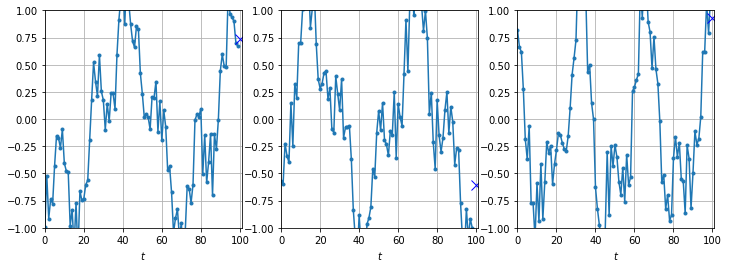

In [12]:
# Synthetic data plotting 함수
def plot_series(series, 
                y=None, 
                y_pred=None):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10, label='Actual')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro",label='Prediction')
    plt.grid(True)
    plt.xlabel("$t$")
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1,
                         ncols=3, 
                         figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0])
plt.show()

In [13]:
# Loss curve plotting하기 
def plot_loss_curves(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history["loss"], label="Training loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## 2) Models

### (1) Simple RNN

In [3]:
simple_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


###  (2) LSTM

In [10]:
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(units=50, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

### (3) Deep RNN

In [14]:
deep_rnn_model = keras.models.Sequential([
    keras.layers.LSTM(units=50, input_shape=[None, 1], return_sequences=True),
    keras.layers.LSTM(units=50, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

## 3) Training & Plotting

### (1) Simple RNN 훈련하기

In [11]:
simple_rnn_model.compile(loss="mse", optimizer="adam")
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 607us/sample - loss: 0.0921 - val_loss: 0.0662
Epoch 2/20
7000/7000 [==============================] - 4s 535us/sample - loss: 0.0678 - val_loss: 0.0658
Epoch 3/20
7000/7000 [==============================] - 4s 543us/sample - loss: 0.0672 - val_loss: 0.0670
Epoch 4/20
7000/7000 [==============================] - 4s 523us/sample - loss: 0.0668 - val_loss: 0.0667
Epoch 5/20
7000/7000 [==============================] - 4s 546us/sample - loss: 0.0662 - val_loss: 0.0666
Epoch 6/20
7000/7000 [==============================] - 4s 543us/sample - loss: 0.0666 - val_loss: 0.0697
Epoch 7/20
7000/7000 [==============================] - 4s 542us/sample - loss: 0.0666 - val_loss: 0.0654
Epoch 8/20
7000/7000 [==============================] - 4s 542us/sample - loss: 0.0653 - val_loss: 0.0652
Epoch 9/20
7000/7000 [==============================] - 4s 545us/sample - loss: 0.0652 - val_loss: 0.066

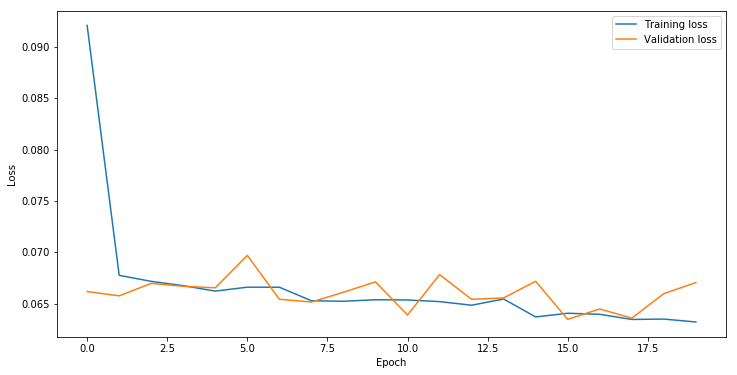

In [12]:
plot_loss_curves(simple_rnn_history)

In [13]:
simple_rnn_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 153us/sample - loss: 0.0669


0.06692407247424126

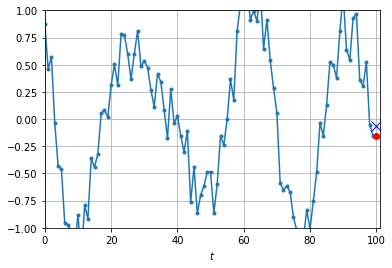

In [14]:
simple_rnn_y_pred = simple_rnn_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], simple_rnn_y_pred[0, 0])
plt.show()

In [15]:
print("Simple RNN Error: {}".format(y_test[0,0] - simple_rnn_y_pred[0,0]))

Simple RNN Error: 0.09325343249000051


### (2) LSTM 훈련하기

In [16]:
# lstm 훈련하기
lstm_model.compile(loss="mse", optimizer="adam")
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.1164 - val_loss: 0.0696
Epoch 2/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0674 - val_loss: 0.0657
Epoch 3/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0659 - val_loss: 0.0633
Epoch 4/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0645 - val_loss: 0.0635
Epoch 5/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0649 - val_loss: 0.0646
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0641 - val_loss: 0.0638
Epoch 7/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0629 - val_loss: 0.0629
Epoch 8/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0624 - val_loss: 0.0622
Epoch 9/20
7000/70

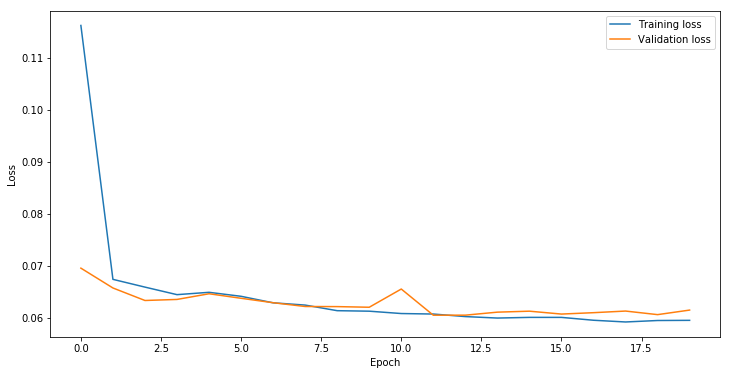

In [17]:
plot_loss_curves(lstm_history)

In [18]:
lstm_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 0s 387us/sample - loss: 0.0608


0.060806256890296936

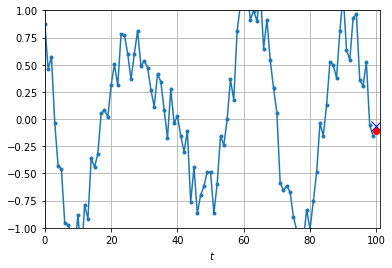

In [19]:
lstm_y_pred = lstm_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], lstm_y_pred[0, 0])
plt.show()

In [20]:
print("LSTM Error: {}".format(y_test[0,0] - lstm_y_pred[0,0]))

LSTM Error: 0.043289675094256186


### (3) Deep RNN 훈련하기

In [16]:
deep_rnn_model.compile(loss="mse", optimizer="adam")
deep_rnn_history = deep_rnn_model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 33s 5ms/sample - loss: 0.0789 - val_loss: 0.0679
Epoch 2/20
7000/7000 [==============================] - 31s 4ms/sample - loss: 0.0680 - val_loss: 0.0674
Epoch 3/20
7000/7000 [==============================] - 30s 4ms/sample - loss: 0.0667 - val_loss: 0.0652
Epoch 4/20
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0659 - val_loss: 0.0645
Epoch 5/20
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0651 - val_loss: 0.0675
Epoch 6/20
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0641 - val_loss: 0.0637
Epoch 7/20
7000/7000 [==============================] - 33s 5ms/sample - loss: 0.0642 - val_loss: 0.0648
Epoch 8/20
7000/7000 [==============================] - 33s 5ms/sample - loss: 0.0637 - val_loss: 0.0622
Epoch 9/20
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0620 - val_loss: 0.0632
Epoch 1

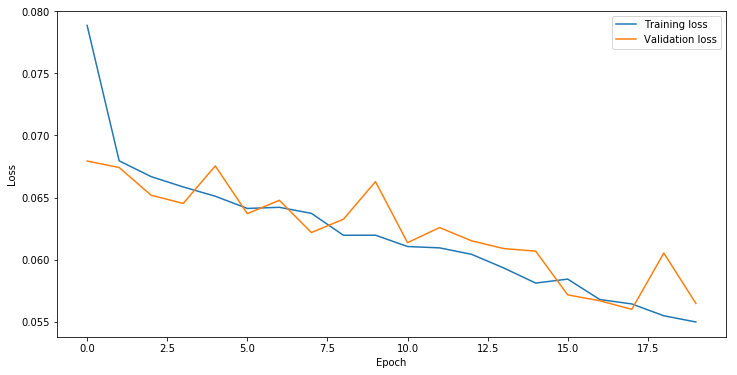

In [17]:
plot_loss_curves(deep_rnn_history)

In [18]:
deep_rnn_model.evaluate(X_test, y_test)

1000/1000 [==============================] - 1s 916us/sample - loss: 0.0551


0.05510118132829666

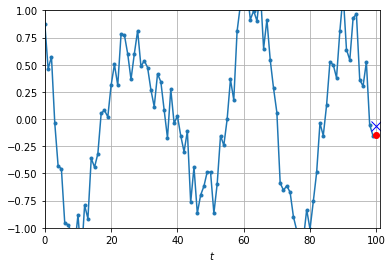

In [19]:
deep_rnn_y_pred = deep_rnn_model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], deep_rnn_y_pred[0, 0])
plt.show()

In [20]:
print("Deep RNN Error: {}".format(y_test[0,0] - deep_rnn_y_pred[0,0]))

Deep RNN Error: 0.08477182564891317
